# Import Libraries

In [69]:
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans, DBSCAN



# Cleaning data

#### Load data

In [35]:
file_path = 'CompleteDataset.csv'
data = pd.read_csv(file_path)

/var/folders/d7/gvtlp77105dbv_x1y63m43h40000gn/T/ipykernel_961/402119981.py:2: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


#### Remove columns containing links to player photos, flags, and club logos

In [36]:
columns_to_remove = ['Photo', 'Flag', 'Club Logo']
data_cleaned = data.drop(columns=columns_to_remove, errors='ignore')

#### Convert "wage" and "value" attributes into numerical values

In [37]:
def convert_currency(value):
    if isinstance(value, str):
        value = value.replace('€', '').replace('M', 'e6').replace('K', 'e3')
        try:
            return int(eval(value))
        except Exception:
            return None
    return value


data_cleaned['Wage'] = data_cleaned['Wage'].apply(convert_currency)
data_cleaned['Value'] = data_cleaned['Value'].apply(convert_currency)

#### Fix inconsistent values in attributes like aggression and dribbling

In [38]:
def fix_inconsistent_values(value):
    if isinstance(value, str) and (re.search(r'\+|-', value)):
        try:
            return sum(map(int, re.split(r'\+|-', value)))
        except Exception:
            return None
    return value

for column in data_cleaned.columns:
    if data_cleaned[column].dtype == 'object':
        data_cleaned[column] = data_cleaned[column].apply(fix_inconsistent_values)

#### Assign zero to empty fields

In [46]:
cleaned_data_filled = data_cleaned.fillna(0)

#### Perform one-hot encoding

In [49]:
data = cleaned_data_filled
preferred_positions_col = 'Preferred Positions'
unique_positions = data[preferred_positions_col].unique()
#print("Unique preferred positions:", unique_positions)

data['Preferred Positions Tokenized'] = data[preferred_positions_col].str.split()

mlb = MultiLabelBinarizer()
one_hot_positions = mlb.fit_transform(data['Preferred Positions Tokenized'])

one_hot_columns = [f"Position_{pos}" for pos in mlb.classes_]
one_hot_df = pd.DataFrame(one_hot_positions, columns=one_hot_columns)
data = pd.concat([data, one_hot_df], axis=1)

processed_file_path = 'CleanedDataset.csv'
data.to_csv(processed_file_path, index=False)

#print(data.head())

# Normalization

In [50]:
file_path = 'CleanedDataset.csv'
data = pd.read_csv(file_path)

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Save the normalized dataset (optional)
normalized_file_path = 'NormalizedDataset.csv'
data.to_csv(normalized_file_path, index=False)

# Display the first few rows of the normalized dataset
#print(data.head())

# Neural network for solving the classification task

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.1407 - loss: 0.6248 - val_accuracy: 0.2522 - val_loss: 0.5441
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.2501 - loss: 0.5518 - val_accuracy: 0.3437 - val_loss: 0.5430
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.3062 - loss: 0.5500 - val_accuracy: 0.3604 - val_loss: 0.5430
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.3234 - loss: 0.5470 - val_accuracy: 0.3942 - val_loss: 0.5424
Epoch 5/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.3364 - loss: 0.5493 - val_accuracy: 0.4418 - val_loss: 0.5423
Epoch 6/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.3609 - loss: 0.5473 - val_accuracy: 0.4505 - val_loss: 0.5422
Epoch 7/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.3611 - loss: 0.5456 - val_accuracy: 0.4004 - val_loss: 0.5424
Epoch 8/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.3582 - loss: 0.5497 - val_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


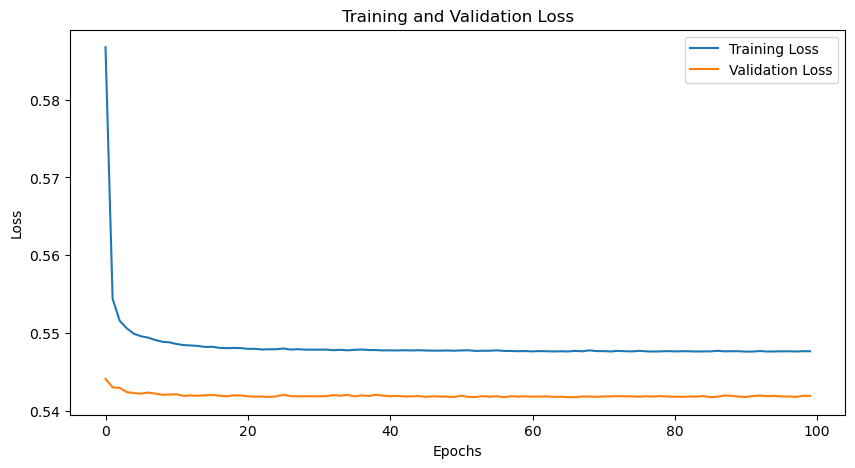

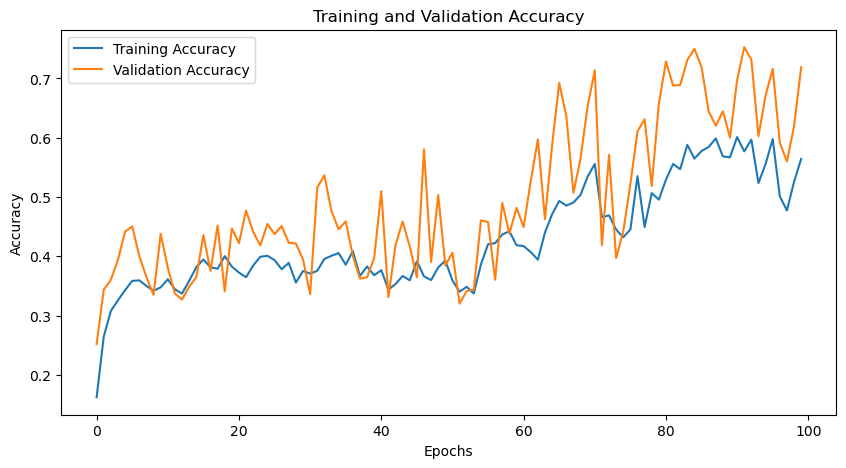

In [53]:
data = pd.read_csv('NormalizedDataset.csv')

# Features and labels
X = data[["Acceleration", "Aggression", "Agility", "Balance", "Ball control",
          "Composure", "Crossing", "Curve", "Dribbling", "Finishing",
          "Free kick accuracy", "GK diving", "GK handling", "GK kicking",
          "GK positioning", "GK reflexes", "Heading accuracy", "Interceptions",
          "Jumping", "Long passing", "Long shots", "Marking", "Penalties",
          "Positioning", "Reactions", "Short passing", "Shot power",
          "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle",
          "Strength", "Vision", "Volleys"]]

y = data[["CF", "RF", "LF", "CM", "RM", "LM", "CB", "RB", "LB"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
#print(f"Reduced dimensions: {X_pca.shape[1]}")


y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

def accuracy(y_true, y_pred):
    y_true_max = tf.argmax(y_true, axis=-1)
    y_pred_max = tf.argmax(y_pred, axis=-1)
    correct_predictions = tf.equal(y_true_max, y_pred_max)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[accuracy])

history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)

test_loss, test_custom_accuracy = model.evaluate(X_test, y_test, verbose=0)
#print(f"Test Loss: {test_loss}")
#print(f"Test Accuracy: {test_custom_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_max_indices = np.argmax(y_pred, axis=1)
y_test_max_indices = np.argmax(y_test, axis=1)

custom_accuracy_test = accuracy_score(y_test_max_indices, y_pred_max_indices)
print(f"Accuracy (based on maximum probability): {custom_accuracy_test * 100:.2f}%")

f1 = f1_score(y_test_max_indices, y_pred_max_indices, average='macro')
precision = precision_score(y_test_max_indices, y_pred_max_indices, average='macro')
recall = recall_score(y_test_max_indices, y_pred_max_indices, average='macro')
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Neural Network for player wage and value prediction (regression task)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.0946 - mae: 0.1900 - val_loss: 0.0019 - val_mae: 0.0248
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0013 - val_mae: 0.0151
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0012 - val_mae: 0.0126
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 0.0012 - mae: 0.0184 - val_loss: 9.2505e-04 - val_mae: 0.0108
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 8.9703e-04 - mae: 0.0155 - val_loss: 8.9782e-04 - val_mae: 0.0104
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0010 - mae: 0.0142 - val_loss: 6.8519e-04 - val_mae: 0.0092
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 7.5756e-04 - mae: 0.0129 - val_loss: 6.4726e-04 - val_mae: 0.0092
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 7.1584e-04 - mae: 0.0124 - val_loss: 8.0468e-04 - val_mae: 0.0104
Epoch 9/50
360/360 

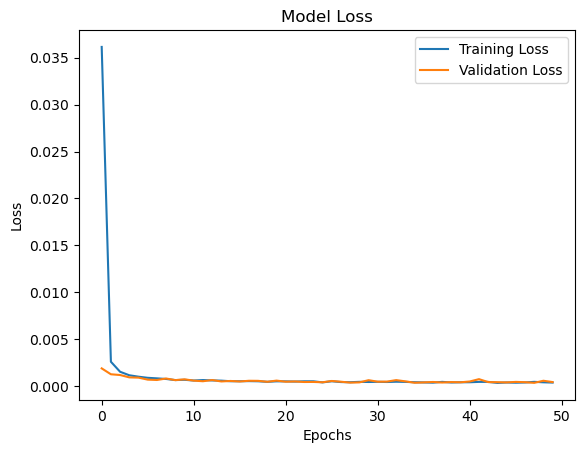

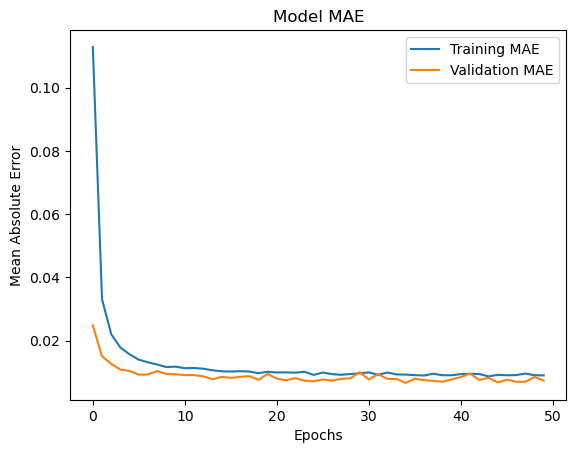

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
Mean Squared Error (MSE): 0.00045516516607128
Root Mean Squared Error (RMSE): 0.021334600208845724


In [70]:
data = pd.read_csv('NormalizedDataset.csv')

features = ["Acceleration", "Aggression", "Agility", "Balance", "Ball control",
            "Composure", "Crossing", "Curve", "Dribbling", "Finishing",
            "Free kick accuracy", "GK diving", "GK handling", "GK kicking",
            "GK positioning", "GK reflexes", "Heading accuracy", "Interceptions",
            "Jumping", "Long passing", "Long shots", "Marking", "Penalties",
            "Positioning", "Reactions", "Short passing", "Shot power",
            "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle",
            "Strength", "Vision", "Volleys"]

X = data[features]
y = data['Value']  # Replace 'Value' with 'Wage'

X = X.fillna(X.mean())
y = y.fillna(y.mean())

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")
#print("Sample Predictions:", predictions[:5])


# Clustering players based on Wage, Value and Age

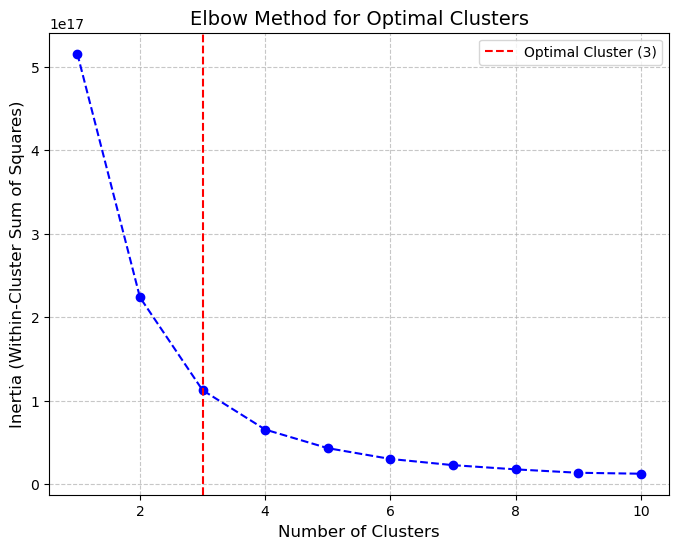

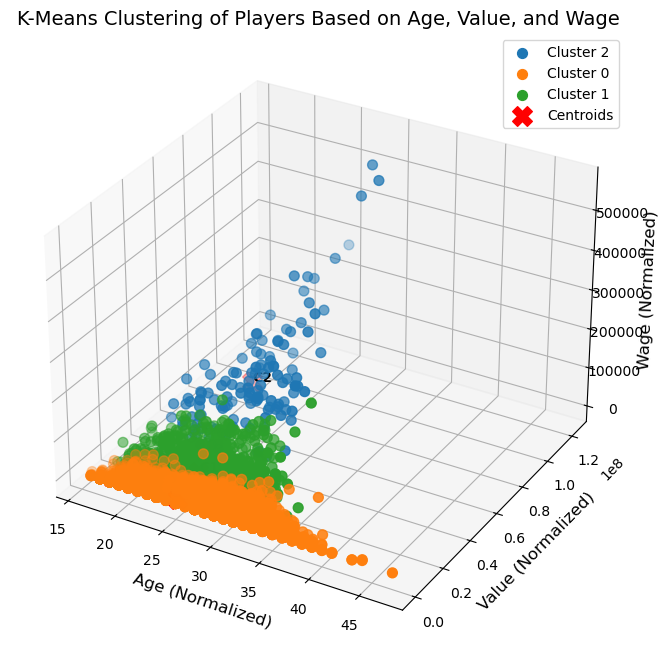

In [71]:
file_path = 'CleanedDataset.csv'
data = pd.read_csv(file_path)

features = ['Age', 'Value', 'Wage']
age_value_wage_data = data[features].copy()

inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(age_value_wage_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--', color='b')
plt.axvline(x=3, color='r', linestyle='--', label='Optimal Cluster (3)')
plt.title("Elbow Method for Optimal Clusters", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia (Within-Cluster Sum of Squares)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Based on the elbow plot, choose the optimal number of clusters (e.g., 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(age_value_wage_data)

age_value_wage_data['Cluster'] = clusters

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in age_value_wage_data['Cluster'].unique():
    cluster_data = age_value_wage_data[age_value_wage_data['Cluster'] == cluster]
    ax.scatter(cluster_data['Age'], cluster_data['Value'], cluster_data['Wage'], label=f"Cluster {cluster}", s=50)

centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], color='red', marker='X', s=200, label='Centroids')
for i, (x, y, z) in enumerate(centroids):
    ax.text(x, y, z, f'C{i}', color='black', fontsize=10, fontweight='bold')

ax.set_title("K-Means Clustering of Players Based on Age, Value, and Wage", fontsize=14)
ax.set_xlabel("Age (Normalized)", fontsize=12)
ax.set_ylabel("Value (Normalized)", fontsize=12)
ax.set_zlabel("Wage (Normalized)", fontsize=12)
plt.legend()
plt.show()


# Anomaly detection task

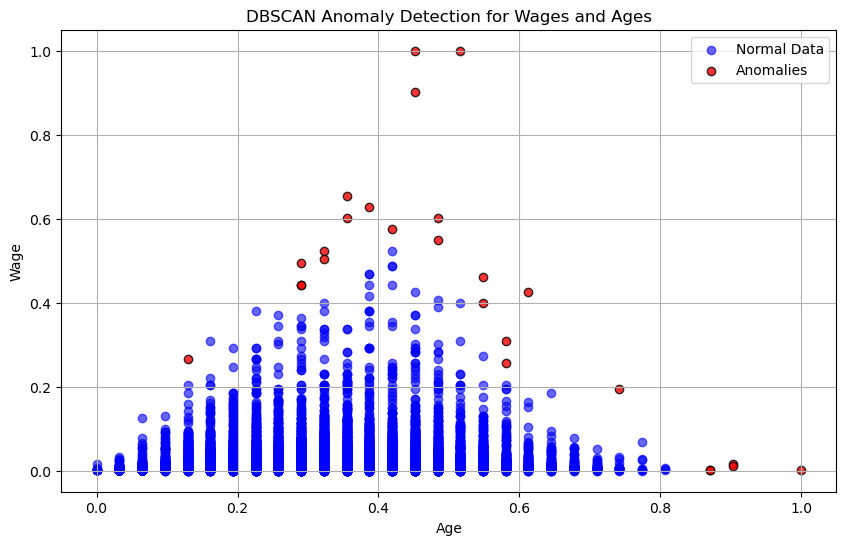

In [29]:
file_path = 'NormalizedDataset.csv'
data = pd.read_csv(file_path)

features = ['Wage', 'Age']
wage_age_data = data[features].copy()

dbscan = DBSCAN(eps=0.05, min_samples=5) 
dbscan_labels = dbscan.fit_predict(wage_age_data)

data['DBSCAN_Labels'] = dbscan_labels

anomalies = data[data['DBSCAN_Labels'] == -1]
normal_data = data[data['DBSCAN_Labels'] != -1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data['Age'], normal_data['Wage'], c='blue', label='Normal Data', alpha=0.6)
plt.scatter(anomalies['Age'], anomalies['Wage'], c='red', label='Anomalies', alpha=0.8, edgecolor='black')
plt.title('DBSCAN Anomaly Detection for Wages and Ages')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.grid(True)
plt.show()

#print("Anomalies detected in Wages and Ages:")
#print(anomalies)


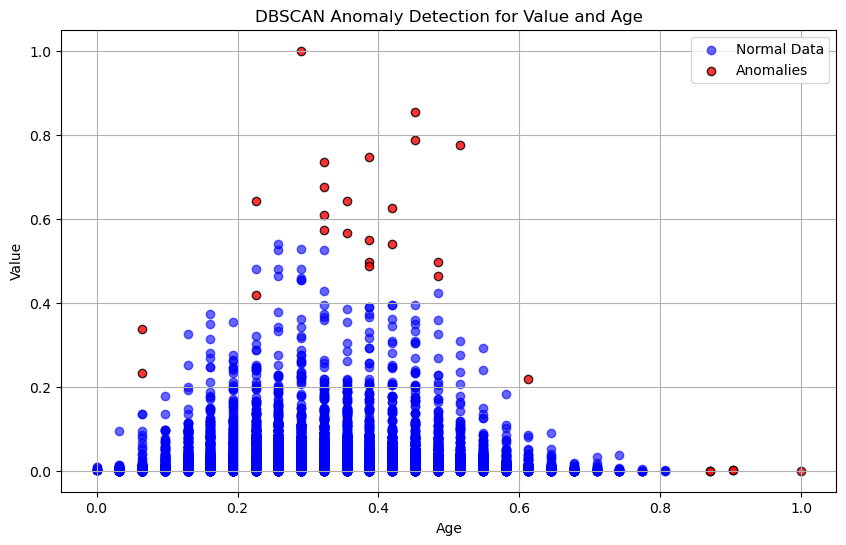

In [30]:
file_path = 'NormalizedDataset.csv'
data = pd.read_csv(file_path)

features = ['Value', 'Age']
value_age_data = data[features].copy()

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan_labels = dbscan.fit_predict(value_age_data)

data['DBSCAN_Labels'] = dbscan_labels

anomalies = data[data['DBSCAN_Labels'] == -1]
normal_data = data[data['DBSCAN_Labels'] != -1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data['Age'], normal_data['Value'], c='blue', label='Normal Data', alpha=0.6)
plt.scatter(anomalies['Age'], anomalies['Value'], c='red', label='Anomalies', alpha=0.8, edgecolor='black')
plt.title('DBSCAN Anomaly Detection for Value and Age')
plt.xlabel('Age')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#print("Anomalies detected in Value and Age:")
#print(anomalies)


# Correlations of the features

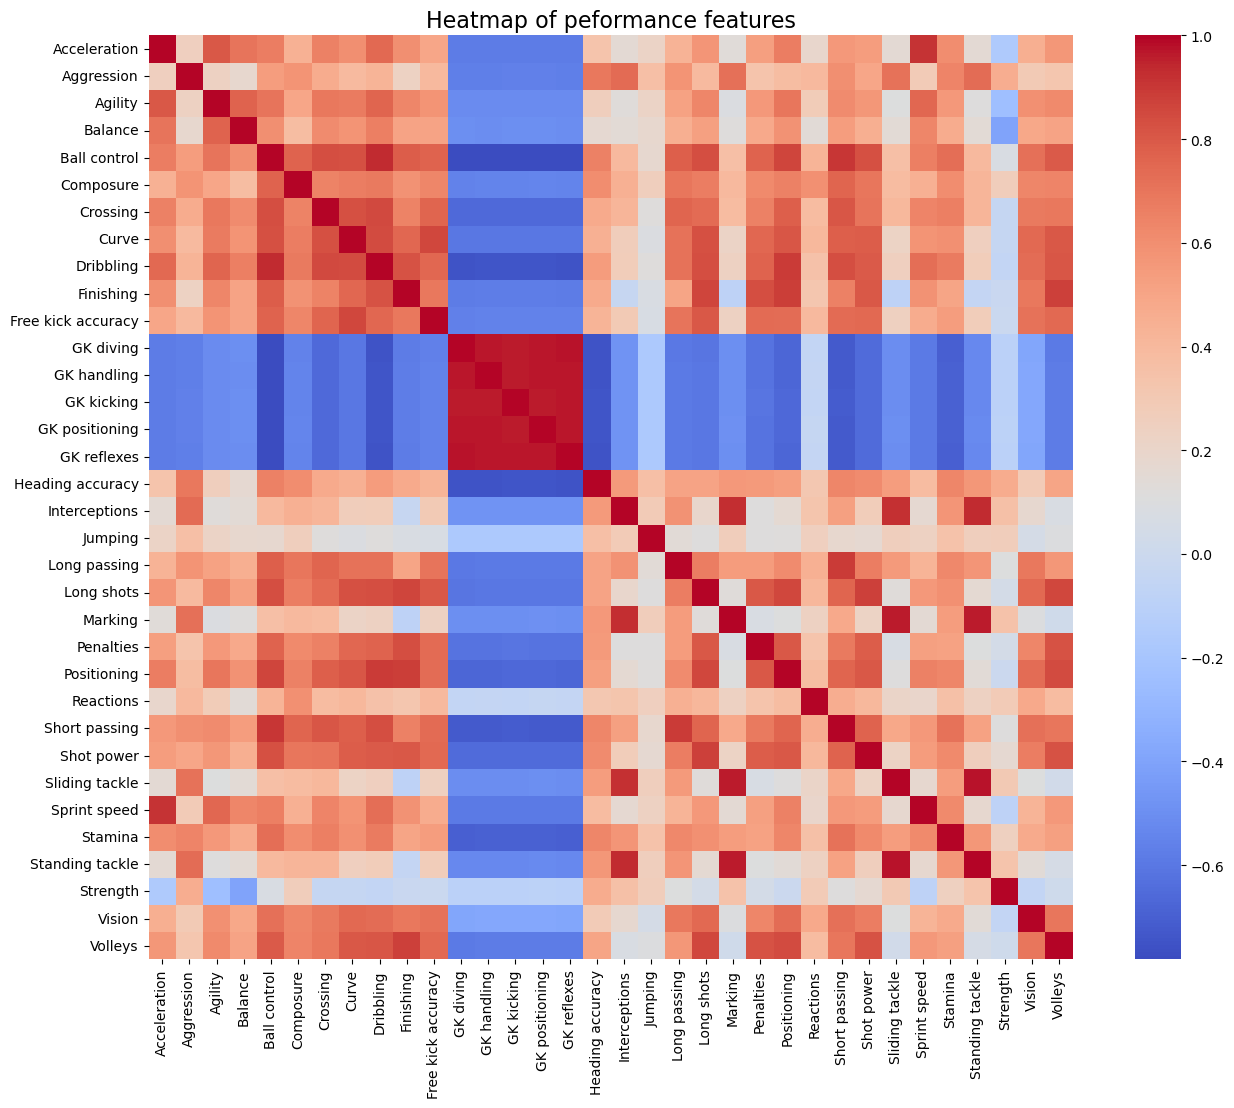

In [74]:
file_path = 'NormalizedDataset.csv'
data = pd.read_csv(file_path)

heatmap_features = [
    "Acceleration", "Aggression", "Agility", "Balance", "Ball control",
    "Composure", "Crossing", "Curve", "Dribbling", "Finishing",
    "Free kick accuracy", "GK diving", "GK handling", "GK kicking",
    "GK positioning", "GK reflexes", "Heading accuracy", "Interceptions",
    "Jumping", "Long passing", "Long shots", "Marking", "Penalties",
    "Positioning", "Reactions", "Short passing", "Shot power",
    "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle",
    "Strength", "Vision", "Volleys"
]

heatmap_data = data[heatmap_features]

correlation_matrix = heatmap_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Heatmap of peformance features", fontsize=16)
plt.show()


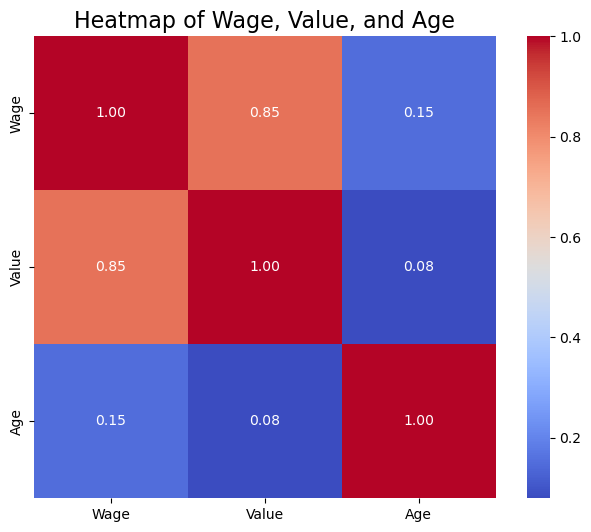

In [64]:
file_path = 'NormalizedDataset.csv'
data = pd.read_csv(file_path)

selected_features = ['Wage', 'Value', 'Age']

heatmap_data = data[selected_features]

correlation_matrix = heatmap_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Heatmap of Wage, Value, and Age", fontsize=16)
plt.show()